In [1]:
import common
import plotting
import importlib
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import socket
import matplotlib.ticker as ticker

import matplotlib.style
matplotlib.style.use('classic')

# Show all columns and rows in a dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Analytics

In [2]:
# graphalytics inserts
sortledton_block_sizeonly = "num_threads_read == 0 and (hostname == 'scyper21' or hostname == 'scyper22') and library == 'sortledton.3' or library == 'sorted_vector_al.6' and graph in ('graph500-22', 'graph500-24', 'graph500-26', 'uniform-24')"


data = common.import_gfe("view_graphalytics_inserts").query(sortledton_block_sizeonly).copy() # data from the experiments
data["build_frequency"].fillna(pd.Timedelta(0), inplace=True) # replace NaT with 0, otherwise the records are ignored in the group by

data = data.groupby(["library", "graph", "block_size", "algorithm"]) \
    .agg(completion_time=("median_secs", "median"), count=("median_secs", "count"))
data = data.unstack("algorithm")[("completion_time")]
data

algorithm                                          bfs        cdlp  \
library            graph          block_size                         
sorted_vector_al.6 graph500-24    1024        0.169685   16.213700   
                   uniform-24     1024        0.163313   39.476652   
sortledton.3       com-friendster 512         5.053727  260.627118   
                   dota-league    512         0.001022    1.170734   
                   graph500-22    512         0.044506    7.326248   
                   graph500-24    16          0.165297   31.975175   
                                  32          0.158436   23.623083   
                                  64          0.157659   21.913115   
                                  128         0.157581   22.783623   
                                  256         0.156484   23.093207   
                                  512         0.159607   23.521098   
                                  1024        0.157453   32.824404   
                                  2048        0.153184   31.337447   
                   graph500-26    512         0.598947  149.688249   
                   uniform-24     512         0.171751   43.936870   
                   uniform-26     512         0.633141  173.083578   

algorithm                                            lcc   pagerank  \
library            graph          block_size                          
sorted_vector_al.6 graph500-24    1024         41.796077   2.125752   
                   uniform-24     1024          3.412015   3.969665   
sortledton.3       com-friendster 512          63.085961  34.759500   
                   dota-league    512          49.754592   0.127522   
                   graph500-22    512           8.387854   0.447248   
                   graph500-24    16          185.775184   4.925753   
                                  32          111.866535   3.559308   
                                  64           77.417981   2.820035   
                                  128          64.812515   2.476586   
                                  256          55.991248   2.299985   
                                  512          47.649419   2.236379   
                                  1024         44.241582   2.201741   
                                  2048         43.026160   2.190112   
                   graph500-26    512         276.867575  11.900861   
                   uniform-24     512           3.748761   4.021060   
                   uniform-26     512          15.913968  20.835272   

algorithm                                          sssp        wcc  
library            graph          block_size                        
sorted_vector_al.6 graph500-24    1024         3.786768   0.636032  
                   uniform-24     1024         8.901694   1.090635  
sortledton.3       com-friendster 512         49.860027  17.143457  
                   dota-league    512          0.277204   0.027643  
                   graph500-22    512          0.824945   0.137254  
                   graph500-24    16           8.091575   1.526682  
                                  32           6.010531   1.102882  
                                  64           5.131479   0.813570  
                                  128          4.268784   0.688123  
                                  256          3.951504   0.658264  
                                  512          3.835369   0.624513  
                                  1024         3.824666   0.627702  
                                  2048         3.715067   0.626452  
                   graph500-26    512         24.281894   3.098358  
                   uniform-24     512          8.303376   1.061033  
                   uniform-26     512         43.973580   5.534944

In [3]:
# Normalize against a sorted vector. Blocksize for the vector is only set as default, it means nothing for the vector.
normalized = data.loc["sortledton.3", "graph500-24", slice(None)] / data.loc["sorted_vector_al.6", "graph500-24", 1024]
normalized = normalized.sort_values(axis=1, by='algorithm')
normalized = normalized.query("block_size != 2048")

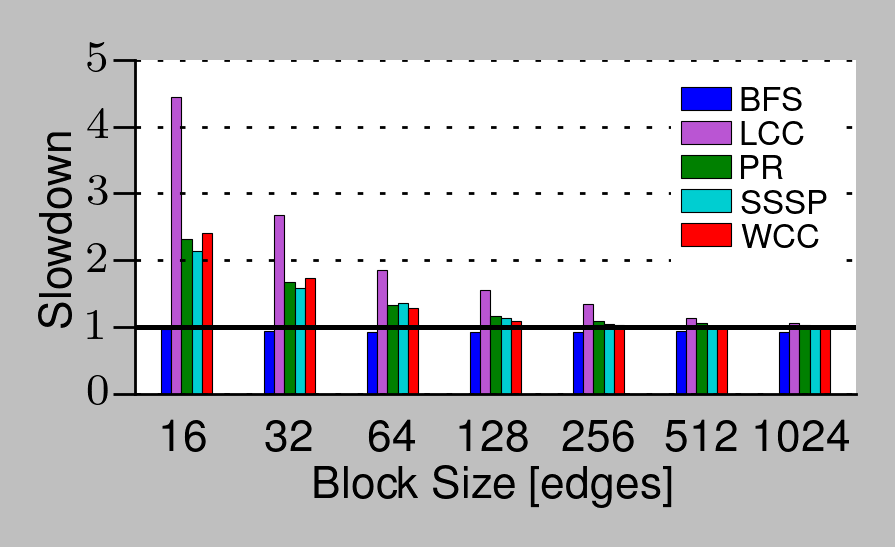

In [4]:
## FIGURE 2b
visualize = normalized.copy()
visualize = visualize.droplevel("library")
visualize = visualize.droplevel("graph")
visualize = visualize.drop("cdlp", axis=1)

colormap=common.set_algorithm_colormap()

plotting.latexify(columns=3)

p = visualize.plot.bar(color=colormap, linewidth=0.2)
plt.xlabel("Block Size [edges]")
plt.ylabel("Slowdown")
plt.xticks(rotation=0)

p.set_ylim(0, 5)

legend_labels = ["BFS", "LCC", "PR", "SSSP", "WCC"]
plt.legend(loc='upper right', labels=legend_labels).get_frame().set_linewidth(0.0)

plotting.add_line_on_1(plt)
plotting.format_axes(p, categorical_x=True)

plt.tight_layout()
plt.savefig(plotting.base_path + "block-sizes-analytics-new.png", dpi=400)

#### Observation

There is no trend that indicates block sizes between 256 and 1024 have major influence on the performance of analytical algorithms.

Below 256 multiple analytical algoritms loose performance. 

## Inserts

In [5]:
sortledton_block_sizeonly = "(hostname == 'scyper21' or hostname == 'scyper22') and library == 'sortledton.3' and graph in ('graph500-22', 'graph500-24', 'graph500-26', 'uniform-24') and block_size != -1"

edges_per_graph = pd.DataFrame({
    "graph": ["friendster", "dota-league", "graph500-22", 
              "graph500-24", "graph500-26", "uniform-22", 
              "uniform-24", "uniform-26"
              ],
    "edges": [1806067135, 50870313, 64155735, 260379520, 1051922853, 64155735, 260379520, 1051922853]
})

data = common.import_gfe("View_Inserts").query(sortledton_block_sizeonly).copy() # data from the experiments
data["build_frequency"].fillna(pd.Timedelta(0), inplace=True) # replace NaT with 0, otherwise the records are ignored in the group by
data = data.merge(edges_per_graph, on="graph")
data["edges_per_second"] = data["edges"] / data["completion_time_secs"]

data_grouped = data.groupby(["graph", "block_size"]) \
    .agg(edges_per_second=("edges_per_second", "median"), count=("edges_per_second", "count"))
#data = data.unstack("algorithm")[("completion_time")]
data_grouped

edges_per_second  count
graph       block_size                         
graph500-22 512             4.104741e+06      6
graph500-24 16              1.663785e+06      6
            32              3.561707e+06      6
            64              4.231400e+06      6
            128             4.352898e+06      5
            256             4.268190e+06      5
            512             3.836104e+06     11
            1024            3.175241e+06      5
            2048            2.245332e+06      5
graph500-26 512             3.713227e+06      6
uniform-24  512             4.737711e+06      7

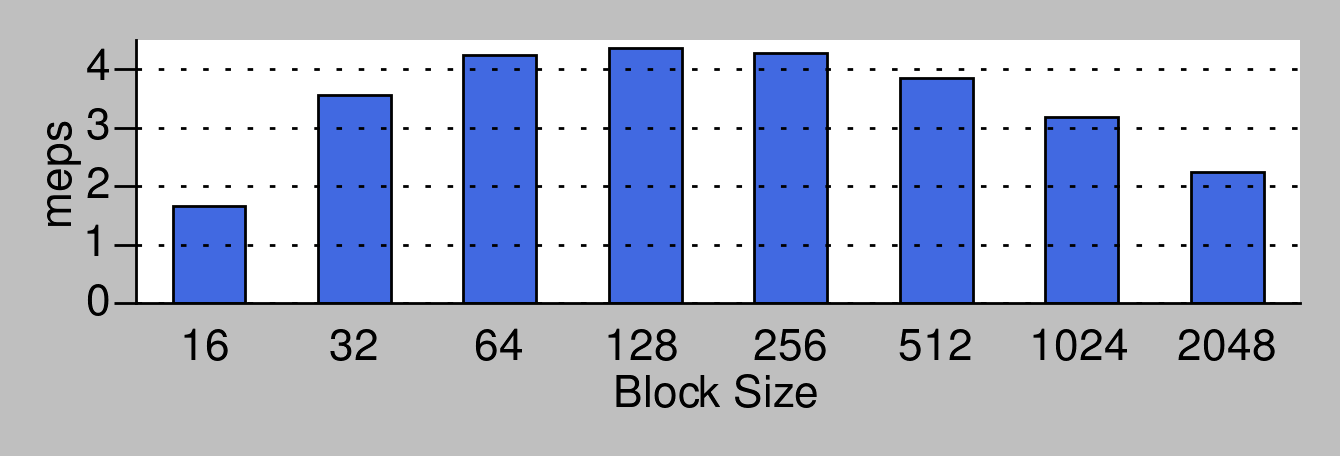

In [6]:
## FIGURE 7

visualize = data_grouped.loc["graph500-24"].copy()
visualize = visualize.drop("count", axis=1)

plotting.latexify(columns=2, fig_height=plotting.cm2inch(3))

p = visualize.plot.bar(color='royalblue',  linewidth=0.5)

plt.xlabel("Block Size")
plt.ylabel("meps")

plt.xticks(rotation=0)

p.get_legend().remove()

scale_y = 1e6
p.yaxis.set_major_locator(ticker.MultipleLocator(scale_y))
p.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: round(x / scale_y)))

plotting.format_axes(p, categorical_x=True)

plt.tight_layout()
plt.savefig(plotting.base_path + "block-sizes-insertions-new.png", dpi=400)

#### Observation

For uniform graphs the block size has no influence on the insertions performance. 
For power-law graphs we see that blocks of sizes of 128 or 256 are best.

#### Explanation

For uniform graphs we do not see the use of many/any blocks because the adjacency set sizes are mostly below.
For power-law graphs small block sizes are better because either finding the correct block is cheaper if performed with skip-list jumps than binary search or/xor there is less data to move, e.g. in the GC.
For too small block sizes we see more random jumps to check the skip list and more memory allocation overhead.

## Result

We run a wider range of block size parameters to
  (1) find the limit when it influences analytical performance.
  (2) find the best block size for insertions

There is no need to run with blocks bigger than 1024 because we do expect insertion performance to decrease without winning analytical performance.
  
We start with the parameters: 8, 32, 64 and 128 on the same graphs.

We find that 512 is the best block size because it is safe to state that analytical algorithms do not suffer and we see good insertion performance.

## Open Question

What happens to the storage size of the data structure?
 We already observed that a block size of 32 cannot be loaded into memory for graph500-26.
What about LCC?